**MNIST/SVHN - CNN (VISASTRAVA) <br>
(version PYTORCH)**
---
PROJET COMPUTER VISION - Anaële BAUDNAT-COJAN & Jaime MONTEALEGRE

In [20]:
# prerequisites
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
from torch.utils.data import Dataset, DataLoader, ConcatDataset, Subset

import matplotlib.pyplot as plt
import IPython.display
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from PIL import Image

In [2]:
# define device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
# DOWNLOAD DATA 

# DOWNLOAD, RESIZE & NORMALIZE MNIST DATASET  (32x32x3 instead of originl 28x28x1)

from torchvision import datasets, transforms
import torch

# Define the transform to resize the image to 32x32 and replicate to 3 channels
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Resize to 32x32
    transforms.Grayscale(num_output_channels=3),  # Convert to RGB by replicating channels
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize each channel (assuming mean 0.5, std 0.5 for simplicity)
])

# Download and load the dataset with the defined transform
train_dataset_source = datasets.MNIST(root='./mnist_data/', train=True, transform=transform, download=True)
test_dataset_source = datasets.MNIST(root='./mnist_data/', train=False, transform=transform, download=True)

# DOWNLOAD, (RESIZE &) NORMALISE, SVHN DATASET (Stret View House Numbers)
train_dataset_target = datasets.SVHN(root='./svhn_data/', split='train', transform=transform, download=True) # transform to insure same shape and normalisation
test_dataset_target = datasets.SVHN(root='./svhn_data/', split='test', transform=transform, download=True)


Using downloaded and verified file: ./svhn_data/train_32x32.mat
Using downloaded and verified file: ./svhn_data/test_32x32.mat


In [4]:

# Extract labels
Ys_train = train_dataset_source.targets.clone().detach()
Ys_test = test_dataset_source.targets.clone().detach()
Yt_train = torch.tensor(train_dataset_target.labels)
Yt_test = torch.tensor(test_dataset_target.labels)

# Calculate weights for the loss function
# Source domain (MNIST)
label_count_source = torch.bincount(Ys_train) 
weights_source = len(Ys_train) /  label_count_source
print('source (MNIST) labels occurence:', label_count_source)
print('source distribution (%):',torch.round(label_count_source/len(Ys_train)*100,decimals = 0))

# Target domain (SVHN)
label_count_target = torch.bincount(Yt_train)
weights_target = len(Yt_train) / label_count_target
print('target (SVHN) labels occurence:', label_count_target)
print('target distribution (%):',torch.round(label_count_target/len(Yt_train)*100,decimals = 0))

source (MNIST) labels occurence: tensor([5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949])
source distribution (%): tensor([10., 11., 10., 10., 10.,  9., 10., 10., 10., 10.])
target (SVHN) labels occurence: tensor([ 4948, 13861, 10585,  8497,  7458,  6882,  5727,  5595,  5045,  4659])
target distribution (%): tensor([ 7., 19., 14., 12., 10.,  9.,  8.,  8.,  7.,  6.])


In [5]:
# Data Loader (Input Pipeline)
bs = 16 # batch size

# MNIST
source_loader_train = torch.utils.data.DataLoader(dataset=train_dataset_source, batch_size=bs, shuffle=True, drop_last=True)
source_loader_test = torch.utils.data.DataLoader(dataset=test_dataset_source, batch_size=bs, shuffle=False, drop_last=True)

# SVHN
target_loader_train = torch.utils.data.DataLoader(dataset=train_dataset_target, batch_size=bs, shuffle=True, drop_last=True)
target_loader_test = torch.utils.data.DataLoader(dataset=test_dataset_target, batch_size=bs, shuffle=False, drop_last=True)

**0/ Data exploration & CNN**
---

In [6]:
# DATASET STRUCTURE
print('train_dataset structure',dir(train_dataset_source))
print('train_dataset length:',len(train_dataset_source),type(train_dataset_source))
print('test_dataset length:',len(test_dataset_source),type(test_dataset_source))
print('images shape:',train_dataset_source[0][0].shape, type(train_dataset_source[0][0]))
labels = torch.unique(train_dataset_source.targets)
print('labels:', labels,type(train_dataset_source[0][1]), type(train_dataset_source.targets), type(train_dataset_source))

train_dataset structure ['__add__', '__annotations__', '__class__', '__class_getitem__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__orig_bases__', '__parameters__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__slots__', '__str__', '__subclasshook__', '__weakref__', '_check_exists', '_check_legacy_exist', '_format_transform_repr', '_is_protocol', '_load_data', '_load_legacy_data', '_repr_indent', 'class_to_idx', 'classes', 'data', 'download', 'extra_repr', 'mirrors', 'processed_folder', 'raw_folder', 'resources', 'root', 'target_transform', 'targets', 'test_data', 'test_file', 'test_labels', 'train', 'train_data', 'train_labels', 'training_file', 'transform', 'transforms']
train_dataset length: 60000 <class 'torchvision.datasets.mnist.MNIST'>
test_dataset length

In [7]:
# CHECK ORGINAL DATASET FORMATS
#------------------------------

# MNIST dataset dimension
print('!!! Transformation for MNIST dataset only visible with the .item() method or, equivalently, in the dataloader !!!\n','!'*110)
print('dimension of X_train_source:',train_dataset_source.data.shape)
print('dimension of X_test_source:',test_dataset_source.data.shape)
mnist_data_train = train_dataset_source.data  # Convert to float for min/max calculation
print('MNIST data type:',type(mnist_data_train))
print('MNIST pixel value range (train):',mnist_data_train.float().min().item(),mnist_data_train.float().max().item())
mnist_data_test = test_dataset_source.data  # Convert to float for min/max calculation
print('MNIST pixel value range (test):',mnist_data_test.float().min().item(),mnist_data_test.float().max().item())

# SVHN dataset dimension
print('\ndimension of X_train_target:',train_dataset_target.data.shape)
print('dimension of X_test_target:',test_dataset_target.data.shape)
svhn_data_train = train_dataset_target.data#.float()  # Convert to float for min/max calculation
print('SVHN data type:',type(svhn_data_train))
print('SVHN pixel value range (train):',svhn_data_train.min().item(),svhn_data_train.max().item())
svhn_data_test = test_dataset_target.data#.float()  # Convert to float for min/max calculation
print('SVHN pixel value range (test):',svhn_data_test.min().item(),svhn_data_test.max().item())


!!! Transformation for MNIST dataset only visible with the .item() method or, equivalently, in the dataloader !!!
 !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
dimension of X_train_source: torch.Size([60000, 28, 28])
dimension of X_test_source: torch.Size([10000, 28, 28])
MNIST data type: <class 'torch.Tensor'>


MNIST pixel value range (train): 0.0 255.0
MNIST pixel value range (test): 0.0 255.0

dimension of X_train_target: (73257, 3, 32, 32)
dimension of X_test_target: (26032, 3, 32, 32)
SVHN data type: <class 'numpy.ndarray'>
SVHN pixel value range (train): 0 255
SVHN pixel value range (test): 0 255


In [8]:
# Retrieve the first batch and check the dimensions

# MNIST
print('MNIST\ndimension of dataloader train (number of batches):',len(source_loader_train),type(source_loader_train  ))
print('dimension of dataloader test (number of batches):',len(source_loader_test),type(source_loader_test  ))
first_batch_data, first_batch_labels = next(iter(source_loader_train))

print('dimension of dataloader 1st batch for data:',first_batch_data.size(),type(first_batch_data))
print('data type:',type(first_batch_data[0,0,0,0].item()),'min:',first_batch_data.min().item(),'max:',first_batch_data.max().item())
print('dimension of dataloader 1st batch for labels:',first_batch_labels.size(),type(first_batch_labels))

# SVHN
print('\nSVHN\ndimension of dataloader train :',len(target_loader_train),type(target_loader_train  ))
print('dimension of dataloader test :',len(target_loader_test),type(target_loader_test  ))
first_batch_data, first_batch_labels = next(iter(target_loader_train))
print('dimension of dataloader 1st batch for data:',first_batch_data.size(),type(first_batch_data))
print('data type:',type(first_batch_data[0,0,0,0].item()),'min:',first_batch_data.min().item(),'max:',first_batch_data.max().item())
print('dimension of dataloader 1st batch for labels:',first_batch_labels.size(),type(first_batch_labels))

MNIST
dimension of dataloader train (number of batches): 3750 <class 'torch.utils.data.dataloader.DataLoader'>
dimension of dataloader test (number of batches): 625 <class 'torch.utils.data.dataloader.DataLoader'>
dimension of dataloader 1st batch for data: torch.Size([16, 3, 32, 32]) <class 'torch.Tensor'>
data type: <class 'float'> min: -1.0 max: 1.0
dimension of dataloader 1st batch for labels: torch.Size([16]) <class 'torch.Tensor'>

SVHN
dimension of dataloader train : 4578 <class 'torch.utils.data.dataloader.DataLoader'>
dimension of dataloader test : 1627 <class 'torch.utils.data.dataloader.DataLoader'>
dimension of dataloader 1st batch for data: torch.Size([16, 3, 32, 32]) <class 'torch.Tensor'>
data type: <class 'float'> min: -0.9215686321258545 max: 0.7333333492279053
dimension of dataloader 1st batch for labels: torch.Size([16]) <class 'torch.Tensor'>


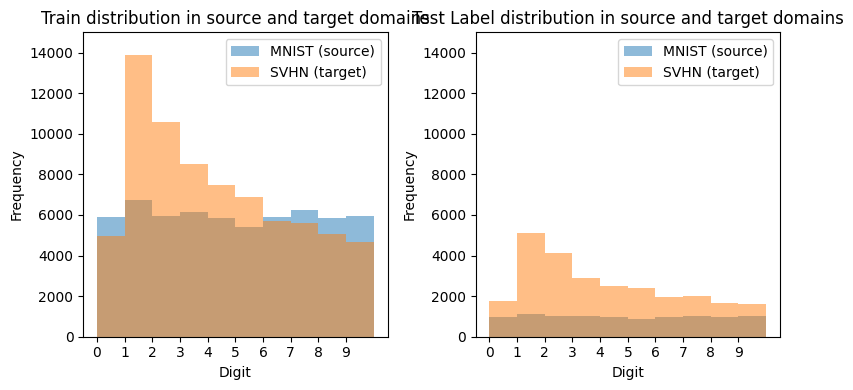

In [9]:
# SHOW TRAIN & TEST DISTRIBUTIONS
#--------------------------------

# Assuming Ys_train, Yt_train, Ys_test, and Yt_test are already defined
# Setup the figure and subplots
fig, axs = plt.subplots(1, 2, figsize=(8, 4))  # 1 row, 2 columns figure

# Plot for train distributions
axs[0].hist(Ys_train.numpy(), bins=range(11), alpha=0.5, label='MNIST (source)')
axs[0].hist(Yt_train.numpy(), bins=range(11), alpha=0.5, label='SVHN (target)')
axs[0].set_xlabel('Digit')
axs[0].set_xticks(range(10))
axs[0].set_ylabel('Frequency')
axs[0].set_ylim([0, 15000])
axs[0].legend()
axs[0].set_title('Train distribution in source and target domains')

# Plot for test distributions
axs[1].hist(Ys_test.numpy(), bins=range(11), alpha=0.5, label='MNIST (source)')
axs[1].hist(Yt_test.numpy(), bins=range(11), alpha=0.5, label='SVHN (target)')
axs[1].set_xlabel('Digit')
axs[1].set_xticks(range(10))
axs[1].set_ylabel('Frequency')
axs[1].set_ylim([0, 15000])
axs[1].legend()
axs[1].set_title('Test Label distribution in source and target domains')

# Show the plot
plt.tight_layout()  # Adjust the layout to make room for the titles/labels
plt.show()


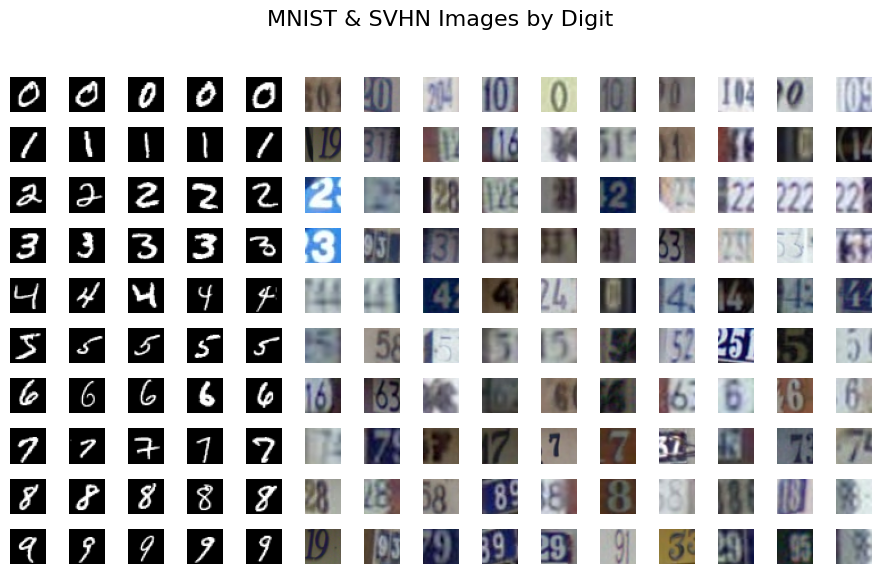

In [10]:
# Visualise numbers from each dataset (first row of 1 : 5 MNIST images of 1, 5 SVHN images of 1, etc.)
#----------------------------------------------------------------------------------------------------

# MNIST
fig, axs = plt.subplots(10, 15, figsize=(9, 6))

for i in range(10):
    
    #show 5 images with label i from MNIST
    idx = (Ys_train == i).nonzero()[:5].squeeze()
        
    for j, index in enumerate(idx):
        # Access and prepare image
        image = train_dataset_source.data[index]
        axs[i, j].imshow(image, cmap='gray')
        axs[i,j].axis('off')

    idx = (Yt_train == i).nonzero()[:10].squeeze()

    for j, index in enumerate(idx):
        # Access and prepare image
        image = train_dataset_target.data[index]
        image=image.transpose((1, 2, 0))
        axs[i, 5+j].imshow(image)
        axs[i,5+j].axis('off')
    
fig.suptitle('MNIST & SVHN Images by Digit', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()



**0/ CNN Model and pseudolabels**
---

For the layers, we use the architecture mentionned in the Ganin article for SVHN inspired by Srivastava et al. 2014 paper, "Dropout: A Simple Way to Prevent Neural Networks from Overfitting" (https://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf).<br>

*"The best architecture that we found uses three convolutional layers each followed by a max-pooling layer. The convolutional layers have 96, 128 and 256 filters respectively.
Each convolutional layer has a 5 × 5 receptive field applied with a stride of 1 pixel. Each max pooling layer pools 3 × 3 regions at strides of 2 pixels. The convolutional layers are followed by two fully connected hidden layers having 2048 units each. All units use the rectified linear activation function. Dropout was applied to all the layers of the network with the probability of retaining the unit being p = (0.9, 0.75, 0.75, 0.5, 0.5, 0.5) for the different layers of the network (going from input to convolutional layers to fully connected layers). In addition, the max-norm constraint with c = 4 was used for all the weights. A momentum of 0.95 was used in all the layers."*

In [11]:
####################################################
# DEFINE A CNN MODEL (WITH SRIVASTAVA ARCHITECTURE)
####################################################

class CNN(nn.Module):
    
    def __init__(self):
        
        super(CNN, self).__init__()
        
        # Convolutional layers with padding
        self.conv1 = nn.Conv2d(3, 96, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(96, 128, kernel_size=5, stride=1, padding=2)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=5, stride=1, padding=2)
        
        # Max pooling
        self.pool = nn.MaxPool2d(kernel_size=3, stride=2)
        
        # Fully connected layers for the main task
        self.fc1_main = nn.Linear(256 * 3 * 3, 2048)  # Adjusted based on feature map size
        self.fc2_main = nn.Linear(2048, 2048)
        self.fc3_main = nn.Linear(2048, 10)

        # Dropout layers
        self.dropout1 = nn.Dropout(p=0.1)
        self.dropout2 = nn.Dropout(p=0.25)
        self.dropout3 = nn.Dropout(p=0.25)
        self.dropout4 = nn.Dropout(p=0.5)
        self.dropout5 = nn.Dropout(p=0.5)
        self.dropout6 = nn.Dropout(p=0.5)

        # Softmax layer for the main task
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        
        # Convolutional layers with ReLU activation and max pooling
        class_x = F.relu(self.pool(self.conv1(x)))
        class_x = self.dropout1(class_x)
        class_x = F.relu(self.pool(self.conv2(class_x)))
        class_x = self.dropout2(class_x)
        class_x = F.relu(self.pool(self.conv3(class_x)))
        class_x = self.dropout3(class_x)
        # Flatten the output for the fully connected layers
        extracted_features = class_x.view(-1, 256 * 3 * 3)
                
        # Fully connected layers for the main task
        class_x = F.relu(self.fc1_main(extracted_features))
        class_x = self.dropout4(class_x)
        class_x = F.relu(self.fc2_main(class_x))
        class_x = self.dropout5(class_x)
        class_x = self.fc3_main(class_x)
        # class_X = self.softmax(class_x) # not needed as we will use nn.CrossEntropyLoss (which automatically applies softmax)

        return class_x




In [27]:
########################################################################################
#
# DEFINE THE TRAINING FUNCTION FOR THE MAIN CLASSIFIER
#
# evaluate_CNN(model, data_loader) : function to evaluate the model during training
# train_CNN(model, loader_train, loader_test, epochs=10, lr=0.001) : function to train the model
#
# get_proba_pred(model, data_loader) : function to get the predictions and probabilities
# get_confusion_matrix( y_pred, y_true, title='') : function to get and show confusion matrix
# get_confusion_matrix_from_loader(model, data_loader,title='') : function to get and show confusion matrix
# generate_pseudo_labels(X, y_pred , y_proba, threshold=0.9) : function to generate pseudo labels
# balance_pseudo_labels(pseudo_labels, confident_indices) : function to balance pseudo labels
#
# SVHNWithPseudoLabels(Dataset) : class to create a dataset with pseudo labels
#
########################################################################################

            
def evaluate_CNN(model, data_loader):
    '''evaluation function to be called every 100 batches and after each epoch''' 
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    #print('Accuracy of the model on the test images: %d %%' % (100 * correct / total))
    
    return correct / total         

def apply_max_norm(model, max_val=4):
    for param in model.parameters():
        norm = param.data.norm(2)
        desired = torch.clamp(norm, 0, max_val)
        scale = desired / (norm + 1e-7)
        param.data.mul_(scale)
        
def train_CNN(model, loader_train, loader_test, epochs=10, lr=0.001):
    '''A function to train the model 
    will evaluate on the test set after each epoch''' 

    # Calculate weights for the loss function
    Y_train = torch.cat([labels for _, labels in loader_train])
    Y_train = Y_train.numpy()
    class_weights = compute_class_weight('balanced', classes = np.unique(Y_train), y = Y_train)
    class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

    # Define the loss function and optimizer
    criterion = nn.CrossEntropyLoss(weight = class_weights)
    optimizer = optim.Adam(model.parameters(), lr=lr)
        
    model.train()
        
    for epoch in range(epochs):
        
        model.train()   
        running_loss = 0.0

        running_loss = 0.0
        running_correct = 0
        total_samples = 0
            
        for i, (images, labels) in enumerate(loader_train):
                
            # Send the data to the device
            images, labels = images.to(device), labels.to(device)
                
            # training step for single batch
            optimizer.zero_grad()
            outputs = model(images) # Forward pass
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Apply max-norm constraint
            # apply_max_norm(model, 4)  # slows down considerably the learning (80% ater 15epochs instead of 97% after 2 epochs)

            # Increment statistics
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            running_correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)

            #Print statistics

            if (i+1) % 100 == 0:
                print(f'Epoch [{epoch + 1}/{epochs}], Batch [{i + 1}/{len(loader_train)}], Loss: {loss.item():.4f}, Running loss: {running_loss/total_samples:.4f}, Running accuracy on train: {round(running_correct / total_samples * 100 , 2):.4f} %')
                #print('Epoch: %d, Batch: %5d, Loss: %.3f' % (epoch + 1, i +1 , loss.item()))
                #print(f'Epoch [{epoch + 1}/{epochs}], Batch [{i + 1}/{len(loader_train)}], Loss: {loss.item():.4f}, Accuracy on train: {evaluate_CNN(model, loader_train[i]):.4f}')        #Evaluation
            
            # reset running statistics
            running_loss = 0.0
            running_correct = 0
            total_samples = 0

        # Evaluate after each epoch
        train_accuracy = evaluate_CNN(model, loader_train)
        test_accuracy = evaluate_CNN(model, loader_test)
        print(f'End of Epoch {epoch + 1}: Train Accuracy: {train_accuracy:.4f}%, Test Accuracy: {test_accuracy:.4f}%')
    
    print('Finished Training')


def get_proba_pred(model, data_loader):
    '''function to get the predictions and probabilities of the model on a dataloader
    '''
    model.eval()
    y_true = []
    y_pred = []
    y_proba = []
    

    # Obtain predicted labels
    with torch.no_grad():
        for images, labels in data_loader:
            pred_batch_logits = model(images.to(device)) # no softmax applied in forward pass (CrossEntropyLoss does it automatically)
            pred_batch_proba = F.softmax(pred_batch_logits, dim=1) # apply softmax to get probabilities
            pred_batch_proba_np = pred_batch_proba.cpu().detach().numpy()       
            _ , pred_batch = torch.max(pred_batch_proba.data, 1)
            pred_batch = pred_batch.cpu().detach().numpy()
            pred_batch_proba = pred_batch_proba.cpu().detach().numpy()
            
            y_true.extend(labels)
            y_pred.extend(pred_batch) 
            y_proba.extend(pred_batch_proba_np)
            
    return y_true, y_pred, y_proba

def get_confusion_matrix( y_pred, y_true, title=''):
    '''a function to get and show confusion matrix from numpy arrays
    '''
    # Create confusion matrix and show it
    cf = confusion_matrix( y_pred, y_true)

    # Print statistics with confusion matrix
    correct_count = np.trace(cf) # sums the diagonal (all true values) 
    accuracy = correct_count / np.sum(cf)

    # Print statistics by class with confusion matrix 
    y_true_count = np.sum(cf,axis=0) # sums the columns (all true values)
    y_pred_count = np.sum(cf,axis=1) # sums the rows (all predicted values)
    y_correct_pred_count = np.diag(cf) # returns the vector of the diagonal (all true values)
    accuracy_by_class = np.round(y_correct_pred_count/y_true_count, 2)
    print('distribution (true label):\n',np.round(y_true_count/len(y_pred)*100,2))
    print('prediction distribution:\n',np.round(y_pred_count/len(y_pred)*100,2))
    print('accuracy by class:\n',np.round(accuracy_by_class*100, 2))

    # Plot the confusion matrix
    plt.figure(figsize=(6, 6))
    sns.heatmap(cf, annot=True, fmt='g', cmap='Blues', cbar=False)
    plt.ylabel('Predicted')
    plt.xlabel('Actual')
    plt.title(f'Confusion Matrix {title} (accuracy {round(accuracy*100,2)}%)')
    plt.show()
    
    return cf


# function to get and show confusion matrix from dataloader

def get_confusion_matrix_from_loader(model, data_loader,title=''):
    '''a function to get and show confusion matrix from a dataloader
    Returns confusion matrix, true labels, predicted labels and probabilities'''
    y_true, y_pred, y_proba = get_proba_pred(model, data_loader)
    cf = get_confusion_matrix( y_pred, y_true, title)
    return cf, y_true, y_pred, y_proba

# get speudo labels for SVHN for confident data
#----------------------------------------------
# Get confident predictions
# Define confidence threshold

def generate_pseudo_labels(X, y_pred , y_proba, threshold=0.9):
    '''function to generate pseudo labels for confident predictions
    '''    
    # Select highest probability for each sample (among vectore of 10 probabilities)
    max_proba = np.max(y_proba, axis=1)  # shape (n,1) from vector of probabilities of shape (n,10)

    # Get confident indices, confident images and pseudo labels
    confident_indices = np.where(max_proba > threshold)[0]
    confident_indices = np.array(confident_indices)
    np.random.shuffle(confident_indices)
    X_confident = X[confident_indices]
    pseudo_labels = np.array(y_pred)[confident_indices]
    return pseudo_labels, confident_indices # X_confident not returned because of numpy array type

def balance_pseudo_labels(pseudo_labels, confident_indices):
    '''function to balance pseudo labels by hedging classes over 10%
    '''
    # check if pseudo labels and indices have the same length
    print(len(pseudo_labels)==len(confident_indices))

    # Get the count and distribution of pseudo labels
    pseudo_labels_count = np.bincount(pseudo_labels)
    print('pseudo labels count:\n',pseudo_labels_count)
    distribution = np.bincount(pseudo_labels)/ len(confident_indices)
    print('distribution of pseudo labels:\n',np.round(distribution*100,2))

    # Hedge the distribution when > 10%
    max_n_per_class = int(0.05 * np.sum(np.maximum(pseudo_labels_count,0.05*len(pseudo_labels))))  # 10% hedge
    print('max number of samples per class (10%):',max_n_per_class)

    # Select indices of pseudo labels to keep for each class
    indices_to_keep = []
    indices_to_remove = []

    for i in range(10):
        indices_i = confident_indices[pseudo_labels == i]
        
        if pseudo_labels_count[i] <= max_n_per_class : # check if there are indices to remove for class i
            indices_to_keep.extend(indices_i) # add all indices to indices_to_keep
        else:
            indices_to_keep_i = np.random.choice(indices_i, max_n_per_class, replace=False) # select randomly indices to keep
            # get indices to remove
            indices_to_remove_i = np.array([ indice for indice in indices_i if indice not in indices_to_keep_i])
            # add indices to keep and to remove to their respective lists
            indices_to_keep.extend(indices_to_keep_i)
            indices_to_remove.extend(indices_to_remove_i)
    
    # format indices to keep and pseudo labels to keep
    indices_to_keep = np.array(indices_to_keep)
    np.random.shuffle(indices_to_keep)
    indices_to_remove = np.array(indices_to_remove)

    # get pseudo labels to keep
    positions_to_keep = [list(confident_indices).index(indice) for indice in indices_to_keep]
    pseudo_labels_to_keep = pseudo_labels[positions_to_keep]

    # print new distribution, number of indices to keep and remove
    balanced_distribution = np.bincount(pseudo_labels_to_keep)/ len(indices_to_keep)
    print('Distribution of balanced pseudo labels:\n',np.round(balanced_distribution*100,2))
    print('Number of samples to keep:',len(indices_to_keep))
    print('Number of samples to remove:',len(indices_to_remove))

    return pseudo_labels_to_keep, indices_to_keep, indices_to_remove

class SVHNWithPseudoLabels(Dataset):
    def __init__(self, original_dataset, confident_indices, pseudolabels):
        """
        original_dataset: The original SVHN dataset object.
        confident_indices: A list of indices for which you have pseudo labels.
        pseudolabels: A list or array of pseudolabels corresponding to the confident_indices.
        """
        self.original_dataset = original_dataset
        self.confident_indices = confident_indices
        self.pseudolabels = pseudolabels

    def __len__(self):
        return len(self.confident_indices)

    def __getitem__(self, idx):
        # Use the confident index to access the original dataset
        original_idx = self.confident_indices[idx]
        image, _ = self.original_dataset[original_idx]  # Get the image, ignore its original label
        pseudolabel = self.pseudolabels[idx]  # Get the pseudolabel corresponding to the confident index
        return image, pseudolabel
    

In [28]:
##############################################
# 1. GROUND TRUTH : TRAINING THE MODEL ON SVHN
##############################################


# Batch Data Loader (Input Pipeline)
bs_CNN = 64 # batch size
source_loader_train_CNN = torch.utils.data.DataLoader(dataset=train_dataset_source, batch_size=bs_CNN, shuffle=True, drop_last=True)
source_loader_test_CNN = torch.utils.data.DataLoader(dataset=test_dataset_source, batch_size=bs_CNN, shuffle=False, drop_last=True)
target_loader_train_CNN = torch.utils.data.DataLoader(dataset=train_dataset_target, batch_size=bs_CNN, shuffle=True, drop_last=True)
target_loader_test_CNN = torch.utils.data.DataLoader(dataset=test_dataset_target, batch_size=bs_CNN, shuffle=False, drop_last=True)

# Instantiate the model
model_CNN = CNN().to(device)
n_epochs = 20

# Train the model !!! KEEP LEARNING RATE = 0.0001 IF ADAM OPTIMISER USED !!!
history_CNN = train_CNN(model_CNN, target_loader_train_CNN, target_loader_test_CNN, epochs=n_epochs, lr=0.0001) #!!! DO NOT CHANGE lr = 0.0001 IF ADAM OPTIMISER USED !!!

# Evaluate the model on the target domain (SVHN)
CF_SVHN, y_true, y_pred, y_proba = get_confusion_matrix_from_loader(model_CNN, target_loader_test_CNN, title='SVHN')

# Evaluate the model on the source domain (MNIST)
cf, y_true, y_pred, y_proba = get_confusion_matrix_from_loader(model_CNN, source_loader_test_CNN, title='MNIST')

Epoch [1/20], Batch [100/1144], Loss: 2.3062, Running loss: 0.0360, Running accuracy on train: 12.5000 %
Epoch [1/20], Batch [200/1144], Loss: 2.3323, Running loss: 0.0364, Running accuracy on train: 17.1900 %
Epoch [1/20], Batch [300/1144], Loss: 1.8807, Running loss: 0.0294, Running accuracy on train: 31.2500 %
Epoch [1/20], Batch [400/1144], Loss: 1.2254, Running loss: 0.0191, Running accuracy on train: 67.1900 %
Epoch [1/20], Batch [500/1144], Loss: 0.8563, Running loss: 0.0134, Running accuracy on train: 78.1200 %
Epoch [1/20], Batch [600/1144], Loss: 1.0261, Running loss: 0.0160, Running accuracy on train: 67.1900 %
Epoch [1/20], Batch [700/1144], Loss: 0.6702, Running loss: 0.0105, Running accuracy on train: 79.6900 %
Epoch [1/20], Batch [800/1144], Loss: 0.4620, Running loss: 0.0072, Running accuracy on train: 87.5000 %
Epoch [1/20], Batch [900/1144], Loss: 0.5113, Running loss: 0.0080, Running accuracy on train: 84.3800 %
Epoch [1/20], Batch [1000/1144], Loss: 0.4245, Running 

In [ ]:
# Plot the training history
plt.plot(history_CNN, )
plt.title('Training History')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

# ATTENTION SVHN IS QUITE IMBALANCED <br>=> NEED TO ADD WEIGHTS TO MODEL

In [14]:
##############################################
# 2. train CNN model on MNIST (source dataset)
##############################################

# Batch Data Loader (Input Pipeline)
bs_CNN = 64 # batch size
source_loader_train_CNN = torch.utils.data.DataLoader(dataset=train_dataset_source, batch_size=bs_CNN, shuffle=True, drop_last=True)
source_loader_test_CNN = torch.utils.data.DataLoader(dataset=test_dataset_source, batch_size=bs_CNN, shuffle=False, drop_last=True)
target_loader_train_CNN = torch.utils.data.DataLoader(dataset=train_dataset_target, batch_size=bs_CNN, shuffle=True, drop_last=True)
target_loader_test_CNN = torch.utils.data.DataLoader(dataset=test_dataset_target, batch_size=bs_CNN, shuffle=False, drop_last=True)

# Instantiate the model
model_CNN = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_CNN.parameters(), lr=0.0001)  # !!! DO NOT CHANGE LEARNING RATE IF ADAM OPTIMISER USED !!!
n_epochs = 3

# Train the model
history_CNN = train_CNN(model_CNN, source_loader_train_CNN, source_loader_test_CNN, epochs=n_epochs, lr=0.0001) #!!! KEEP LEARNING RATE = 0.0001 IF ADAM OPTIMISER USED !!!

Epoch [1/3], Batch [100/937], Loss: 0.7592, Running loss: 0.0119, Running accuracy on train: 68.7500 %
Epoch [1/3], Batch [200/937], Loss: 0.4279, Running loss: 0.0067, Running accuracy on train: 89.0600 %
Epoch [1/3], Batch [300/937], Loss: 0.3687, Running loss: 0.0058, Running accuracy on train: 93.7500 %
Epoch [1/3], Batch [400/937], Loss: 0.1230, Running loss: 0.0019, Running accuracy on train: 96.8800 %
Epoch [1/3], Batch [500/937], Loss: 0.0676, Running loss: 0.0011, Running accuracy on train: 98.4400 %
Epoch [1/3], Batch [600/937], Loss: 0.0514, Running loss: 0.0008, Running accuracy on train: 98.4400 %
Epoch [1/3], Batch [700/937], Loss: 0.0610, Running loss: 0.0010, Running accuracy on train: 98.4400 %
Epoch [1/3], Batch [800/937], Loss: 0.0515, Running loss: 0.0008, Running accuracy on train: 96.8800 %
Epoch [1/3], Batch [900/937], Loss: 0.0651, Running loss: 0.0010, Running accuracy on train: 96.8800 %
End of Epoch 1: Train Accuracy: 0.9848%, Test Accuracy: 0.9873%
Epoch [2/

distribution (true label):
 [ 9.81 11.35 10.32 10.1   9.82  8.91  9.58 10.29  9.75 10.1 ]
prediction distribution:
 [ 9.8  11.36 10.39 10.03  9.98  8.82  9.53 10.24  9.69 10.19]
accuracy by class:
 [ 99. 100. 100.  99. 100.  98.  99.  98.  99.  99.]


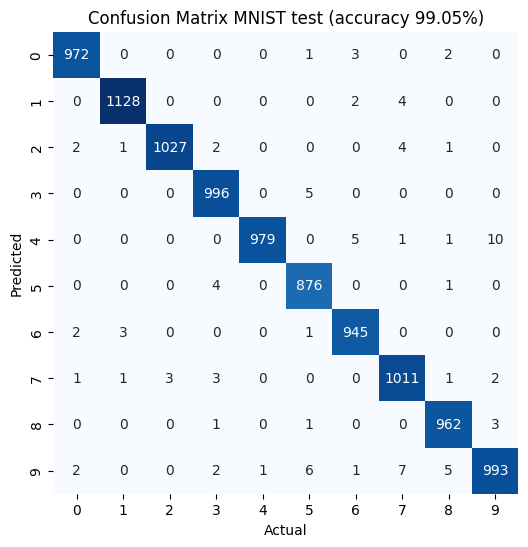

distribution (true label):
 [ 6.7  19.59 15.94 11.07  9.69  9.16  7.58  7.76  6.38  6.13]
prediction distribution:
 [15.86 26.52  9.6   2.58 15.48  5.33  2.73  3.59 11.9   6.41]
accuracy by class:
 [44. 59. 33. 17. 37. 28. 19. 25. 29. 17.]


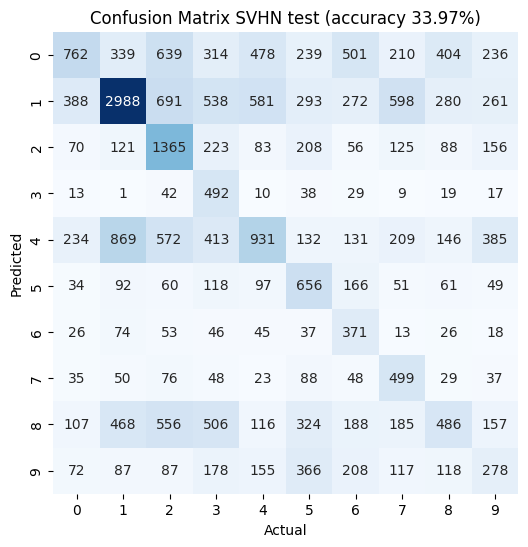

probabilities min/max: 3.9037644e-17 1.0
predictions: [0 1 2 3 4 5 6 7 8 9]


In [15]:
# Get predictions and show confusion matrices

# Ys_train, Ys_pred_train, Ys_proba_train = get_proba_pred(model_CNN, source_loader_train_CNN)
# CFs_train = get_confusion_matrix( Ys_pred_train, Ys_train, title='MNIST train') 

# CFs_train, Ys_train, Ys_pred_train, Ys_proba_train = get_confusion_matrix_from_loader(model_CNN, source_loader_train_CNN,'MNIST train')
CFs_test , Ys_test, Ys_pred_test, Ys_proba_test = get_confusion_matrix_from_loader(model_CNN, source_loader_test_CNN,'MNIST test')
CFt_test, Yt_test, Yt_pred_test, Yt_proba_test = get_confusion_matrix_from_loader(model_CNN, target_loader_test_CNN,'SVHN test')

# check predictions and probabilities outputs
print('probabilities min/max:',np.min(Ys_proba_test),np.max(Ys_proba_test))
print('predictions:', np.unique(Ys_pred_test))

Number of confident samples: 3050
distribution of pseudo labels:
 [ 4.69 36.43  8.39  5.54 23.38  6.72  3.08  4.33  6.07  1.38] 

distribution (true label):
 [ 5.31 29.48 10.95  7.18 18.26  7.44  3.74  6.56  5.67  5.41]
prediction distribution:
 [ 4.69 36.43  8.39  5.54 23.38  6.72  3.08  4.33  6.07  1.38]
accuracy by class:
 [76. 95. 69. 77. 91. 87. 68. 62. 84. 21.]


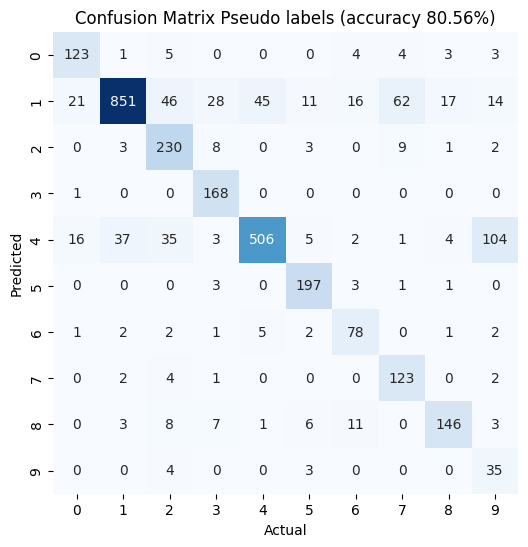


Balancing pseudo labels
True
pseudo labels count:
 [ 143 1111  256  169  713  205   94  132  185   42]
distribution of pseudo labels:
 [ 4.69 36.43  8.39  5.54 23.38  6.72  3.08  4.33  6.07  1.38]
max number of samples per class (10%): 162
Distribution of balanced pseudo labels:
 [10.34 11.71 11.71 11.71 11.71 11.71  6.8   9.54 11.71  3.04]
Number of samples to keep: 1383
Number of samples to remove: 1667
distribution (true label):
 [ 9.4  10.7  13.23 13.16  8.82 12.29  6.87 10.48  9.76  5.28]
prediction distribution:
 [10.34 11.71 11.71 11.71 11.71 11.71  6.8   9.54 11.71  3.04]
accuracy by class:
 [95. 86. 78. 88. 93. 92. 82. 85. 94. 48.]


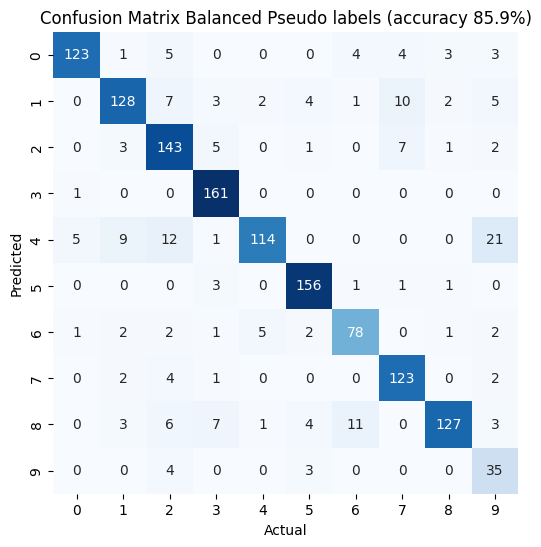

In [16]:
#########################################################################
# 3/ GET PSEUDO LABELS ON SVHN AND RETRAIN MODEL (MNIST + SVHN_confident)
#########################################################################

#---------------------------------------------
# GET PSEUDO LABELS AND BALANCED PSEUDO LABELS
#---------------------------------------------

# get predictions for SVHN_train
Yt_train, Yt_pred_train, Yt_proba_train = get_proba_pred(model_CNN, target_loader_train_CNN)

# get pseudo-label indices
#--------------------------------
pseudo_labels, confident_indices = generate_pseudo_labels(train_dataset_target.data, Yt_pred_train, Yt_proba_train, threshold=0.55) #with 0.55, 2nd label proba at least at 0.45 (=10% margin)

print('Number of confident samples:', len(confident_indices))
print('distribution of pseudo labels:\n',np.round(np.bincount(pseudo_labels)/len(confident_indices)*100,2),'\n')

# show confusion matrix between pseudo labels and true labels
Y_confident = np.array(Yt_train)[confident_indices] # get true labels for confident data
cf_pseudo = get_confusion_matrix(pseudo_labels, Y_confident, title='Pseudo labels')

# get BALANCED pseudo-labels
#----------------------------
print('\nBalancing pseudo labels')
pseudo_labels_balanced, confident_indices_balanced, confident_indices_to_remove = balance_pseudo_labels(pseudo_labels, confident_indices)

# show confusion matrix between balanced pseudo labels and true labels
Y_confident_balanced = np.array(Yt_train)[confident_indices_balanced] # get true labels for confident data
cf_pseudo_balanced = get_confusion_matrix(pseudo_labels_balanced, Y_confident_balanced, title='Balanced Pseudo labels')


3050
shape of 1st image in original dataset: (3, 32, 32) <class 'numpy.ndarray'>
shape of 1st image in pseudo dataset: torch.Size([3, 32, 32]) <class 'torch.Tensor'>
Epoch [1/2], Batch [100/3940], Loss: 2.2346, Running loss: 0.1397, Running accuracy on train: 6.2500 %
Epoch [1/2], Batch [200/3940], Loss: 0.6260, Running loss: 0.0391, Running accuracy on train: 75.0000 %
Epoch [1/2], Batch [300/3940], Loss: 0.4344, Running loss: 0.0271, Running accuracy on train: 81.2500 %
Epoch [1/2], Batch [400/3940], Loss: 0.3121, Running loss: 0.0195, Running accuracy on train: 87.5000 %
Epoch [1/2], Batch [500/3940], Loss: 0.3253, Running loss: 0.0203, Running accuracy on train: 87.5000 %
Epoch [1/2], Batch [600/3940], Loss: 0.1290, Running loss: 0.0081, Running accuracy on train: 93.7500 %
Epoch [1/2], Batch [700/3940], Loss: 0.2307, Running loss: 0.0144, Running accuracy on train: 93.7500 %
Epoch [1/2], Batch [800/3940], Loss: 0.2388, Running loss: 0.0149, Running accuracy on train: 93.7500 %
Epo

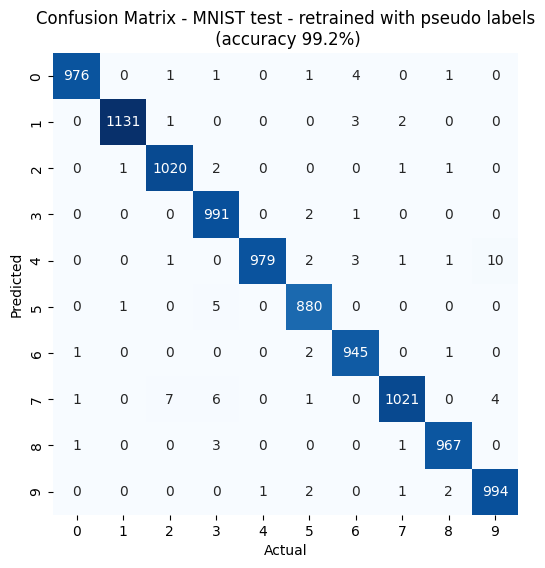

distribution (true label):
 [ 6.7  19.59 15.94 11.07  9.69  9.16  7.58  7.76  6.38  6.13]
prediction distribution:
 [ 0.19 90.6   0.5   0.32  6.83  0.37  0.28  0.54  0.28  0.1 ]
accuracy by class:
 [ 2. 96.  3.  3. 18.  4.  3.  3.  3.  1.]


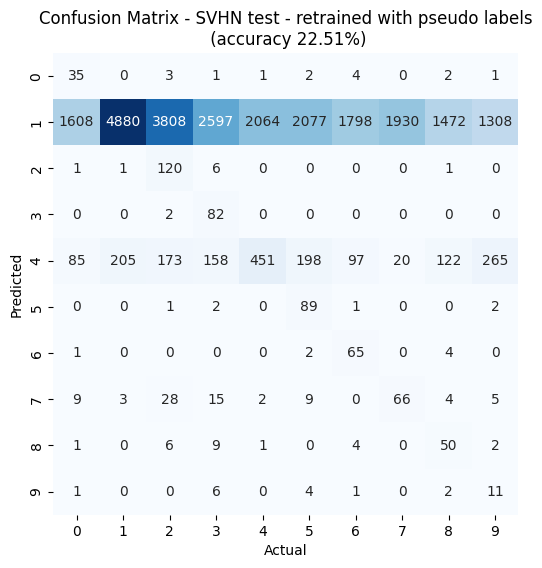

In [17]:
#------------------------------------------------------------------
# 3.1 CREATE NEW DATASET WITH CONFIDENT IMAGES & RETRAIN CNN MODEL
## WITH ALL PSEUDO LABELS (not balanced)
#------------------------------------------------------------------

from torch.utils.data import ConcatDataset
from torch.utils.data import Dataset

# Wrap the original dataset
dataset_with_pseudolabels = SVHNWithPseudoLabels(train_dataset_target, confident_indices, pseudo_labels)
print(len(dataset_with_pseudolabels))
pseudo_loader = DataLoader(dataset_with_pseudolabels, batch_size=bs, shuffle=True, drop_last=True)

# print shape and type of 1st image in each dataset
print('shape of 1st image in original dataset:',train_dataset_target.data[0].shape, type(train_dataset_target.data[0]))
print('shape of 1st image in pseudo dataset:',dataset_with_pseudolabels[0][0].shape, type(dataset_with_pseudolabels[0][0]))

# Concatenante MNIST and pseudo datasets
new_training_dataset = ConcatDataset([train_dataset_source, dataset_with_pseudolabels])
new_training_loader = DataLoader(new_training_dataset, batch_size=bs, shuffle=True, drop_last=True)

# train CNN model on NEW TRAINING DATASET
#----------------------------------------

model_CNN_pseudo = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_CNN_pseudo.parameters(), lr=0.0001)  # !!! DO NOT CHANGE LEARNING RATE IF ADAM OPTIMISER USED !!!
n_epochs = 2    # 2 batches = best result with batch size of 64

# Train the model (with new_training_loader)
history_CNN_pseudo = train_CNN(model_CNN_pseudo, new_training_loader, source_loader_test_CNN, epochs=n_epochs, lr=0.0001) #!!! KEEP LEARNING RATE = 0.0001 IF ADAM OPTIMISER USED !!!

# Get predictions and show confusion matrices
#---------------------------------------------
# Evaluate with MNIST_test and show confusion matrices
CFt_test, Yt_test, Yt_pred_test, Yt_proba_test = get_confusion_matrix_from_loader(model_CNN_pseudo, source_loader_test_CNN,'- MNIST test - retrained with pseudo labels\n')

# Evaluate with SVHN test and show confusion matrices
CFt_test, Yt_test, Yt_pred_test, Yt_proba_test = get_confusion_matrix_from_loader(model_CNN_pseudo, target_loader_test_CNN,'- SVHN test - retrained with pseudo labels\n')

In [18]:
#--------------------------------------------------------------
# CREATE NEW DATASET WITH CONFIDENT IMAGES & RETRAIN CNN MODEL
# WITH BALANCED PSEUDO LABELS
#--------------------------------------------------------------



# Wrap the original dataset WITH BALANCED pseudo labels
dataset_with_pseudolabels = SVHNWithPseudoLabels(train_dataset_target, confident_indices_balanced, pseudo_labels_balanced)
print('number of pseudo labels',len(dataset_with_pseudolabels))
pseudo_loader = DataLoader(dataset_with_pseudolabels, batch_size=bs, shuffle=True, drop_last=True)

# Concatenante MNIST and pseudo datasets
new_training_dataset = ConcatDataset([train_dataset_source, dataset_with_pseudolabels])
new_training_loader = DataLoader(new_training_dataset, batch_size=bs, shuffle=True, drop_last=True)

# train CNN model on NEW TRAINING DATASET
#----------------------------------------

model_CNN_pseudo_balanced = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_CNN_pseudo_balanced.parameters(), lr=0.0001)  # !!! DO NOT CHANGE LEARNING RATE IF ADAM OPTIMISER USED !!!
n_epochs = 3

# Train the model (with new_training_loader)
history_CNN_pseudo_balanced = train_CNN(model_CNN_pseudo_balanced, new_training_loader, source_loader_test_CNN, epochs=n_epochs, lr=0.0001) #!!! KEEP LEARNING RATE = 0.0001 IF ADAM OPTIMISER USED !!!

# Get predictions and show confusion matrices
#---------------------------------------------
# Evaluate with MNIST_test and show confusion matrices
CFt_test_balanced, Yt_test, Yt_pred_test, Yt_proba_test = get_confusion_matrix_from_loader(model_CNN_pseudo_balanced, source_loader_test_CNN,'- MNIST test - retrained with BALANCED pseudo labels\n')

# Evaluate with SVHN test and show confusion matrices
CFt_test_balanced, Yt_test, Yt_pred_test, Yt_proba_test = get_confusion_matrix_from_loader(model_CNN_pseudo_balanced, target_loader_test_CNN,'- SVHN test - retrained with BALANCED pseudo labels\n')

number of pseudo labels 1383
Epoch [1/3], Batch [100/3836], Loss: 2.2346, Running loss: 0.1397, Running accuracy on train: 18.7500 %
Epoch [1/3], Batch [200/3836], Loss: 1.4308, Running loss: 0.0894, Running accuracy on train: 56.2500 %
Epoch [1/3], Batch [300/3836], Loss: 0.6899, Running loss: 0.0431, Running accuracy on train: 81.2500 %
Epoch [1/3], Batch [400/3836], Loss: 0.2032, Running loss: 0.0127, Running accuracy on train: 87.5000 %
Epoch [1/3], Batch [500/3836], Loss: 0.3675, Running loss: 0.0230, Running accuracy on train: 87.5000 %
Epoch [1/3], Batch [600/3836], Loss: 0.0727, Running loss: 0.0045, Running accuracy on train: 100.0000 %
Epoch [1/3], Batch [700/3836], Loss: 0.1519, Running loss: 0.0095, Running accuracy on train: 93.7500 %
Epoch [1/3], Batch [800/3836], Loss: 0.2812, Running loss: 0.0176, Running accuracy on train: 87.5000 %
Epoch [1/3], Batch [900/3836], Loss: 0.0286, Running loss: 0.0018, Running accuracy on train: 100.0000 %
Epoch [1/3], Batch [1000/3836], L

KeyboardInterrupt: 

# => LE MODEL CNN N'A RIEN APPRIS DE PLUS SUR SVHN AVEC LES PSEUDO LABELS !!! 
**Au contraire, le nombre de pseudo label = échantillon ! les pseudo labels sont très imbalanced et le modèle a appris à prédire principalement la classe majoritaire (1) pour SVHN. L'accuracy sur SVHN est tombée de 35% à 22-24% avec l'ajout des pseudo labels aux données d'entrainement.**

**1/ DANN (Domain Adversarial Neural Network)**
---
DANN is a model that can be used for domain adaptation. It is a neural network that is trained to predict the label of an image, while being invariant to the domain of the image. In this project, we will use the DANN model to adapt the MNIST dataset to the SVHN dataset.<br>

We will replicate the DANN mentionned in the Ganin et al. 2016 paper "Domain-Adversarial Training of Neural Networks" (https://arxiv.org/abs/1505.07818), with the Gradient Reversal Layer (GRL). 
It consists of the following architecture:<br>
- A feature extractor (CNN) that extracts features from the input image
- A label predictor (MLP) that predicts the label of the image
- A domain classifier (MLP) that predicts the domain of the image

For the layers, we use the architecture mentionned in the Ganin article for SVHN inspired Srivastava et al. 2014 paper, "Dropout: A Simple Way to Prevent Neural Networks from Overfitting" (https://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf).<br>

*"The best architecture that we found uses three convolutional layers each followed by a max-pooling layer. The convolutional layers have 96, 128 and 256 filters respectively.
Each convolutional layer has a 5 × 5 receptive field applied with a stride of 1 pixel. Each max pooling layer pools 3 × 3 regions at strides of 2 pixels. The convolutional layers are followed by two fully connected hidden layers having 2048 units each. All units use the rectified linear activation function. Dropout was applied to all the layers of the network with the probability of retaining the unit being p = (0.9, 0.75, 0.75, 0.5, 0.5, 0.5) for the different layers of the network (going from input to convolutional layers to fully connected layers). In addition, the max-norm constraint with c = 4 was used for all the weights. A momentum of 0.95 was used in all the layers."*


In [ ]:
######################################################################
# Classes necessary for Domain adversairial neural network (DANN)
# with architecture inspired by the paper Srivatavas et al. (2014) on SVHN
#
# class GradReversal(torch.autograd.Function): custom layer for gradient reversal
# class GradientReversalLayer(nn.Module): custom layer for gradient reversal
# class DANN_Srivastavas(nn.Module): DANN model based on Srivastavas et al. (2014)
#
######################################################################


# GRL - Gradient Reversal Layer
#------------------------------

# creation of a custom autograd function for gradient reversal

class GradReversal(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha
        return x.view_as(x)
    
    @staticmethod
    def backward(ctx, grad_output):
        alpha = ctx.alpha
        grad_input = grad_output.neg() * alpha
        return grad_input, None

# creation of a custom layer inheriting from nn.Module

class GradientReversalLayer(nn.Module):
    def __init__(self, alpha=1.0):
        super(GradientReversalLayer, self).__init__()
        self.alpha = alpha

    def forward(self, input):
        return GradReversal.apply(input, self.alpha)

# DANN model (based on Srivastavas et al. (2014))
#-------------------------------------------------

class DANN_Srivastavas(nn.Module):

    def __init__(self, alpha=0.0001):
        super(DANN_Srivastavas, self).__init__()
        
        # Convolutional layers with padding
        self.conv1 = nn.Conv2d(3, 96, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(96, 128, kernel_size=5, stride=1, padding=2)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=5, stride=1, padding=2)
        
        # Max pooling
        self.pool = nn.MaxPool2d(kernel_size=3, stride=2)
        
        # Fully connected layers for the main task
        self.fc1_main = nn.Linear(256 * 3 * 3, 2048)  # Adjusted based on feature map size
        self.fc2_main = nn.Linear(2048, 2048)
        self.fc3_main = nn.Linear(2048, 10)
        
        # Fully connected layers for the domain classifier task
        self.fc1_domain = nn.Linear(256 * 3 * 3, 2048)  # Adjusted based on feature map size
        self.fc2_domain = nn.Linear(2048, 1)
        
        # Gradient Reversal Layer
        self.grl = GradientReversalLayer(alpha=alpha)

        # Dropout layers
        self.dropout1 = nn.Dropout(p=0.1)
        self.dropout2 = nn.Dropout(p=0.25)
        self.dropout3 = nn.Dropout(p=0.25)
        self.dropout4 = nn.Dropout(p=0.5)
        self.dropout5 = nn.Dropout(p=0.5)
        self.dropout6 = nn.Dropout(p=0.5)

    def forward(self, x):
    
        # Split combined_data into source_data and target_data
        half_size = x.size(0) // 2
        source_data = x[:half_size] # first half of X is source data (MNIST) by construction of training function

        # Forward pass for source data
        class_x = F.relu(self.pool(self.conv1(source_data)))
        class_x = self.dropout1(class_x)
        class_x = F.relu(self.pool(self.conv2(class_x)))
        class_x = self.dropout2(class_x)
        class_x = F.relu(self.pool(self.conv3(class_x)))
        # Flatten the output for the fully connected layers
        extracted_features_source = self.dropout3(class_x)

        # Forward pass for the main task classifier
        class_x = extracted_features_source.view(-1, 256 * 3 * 3)
        class_x = self.dropout4(F.relu(self.fc1_main(class_x)))
        class_x = self.dropout5(F.relu(self.fc2_main(class_x)))
        main_class_output = self.fc3_main(class_x) # logits
        #main_class_output = torch.softmax(class_x, dim=1) # softmax is already automatically included in the loss function nn.CrossEntropyLoss()

        # Forward pass for combined data
        domain_x = F.relu(self.pool(self.conv1(x)))
        domain_x = self.dropout1(domain_x)
        domain_x = F.relu(self.pool(self.conv2(domain_x)))
        domain_x = self.dropout2(domain_x)
        domain_x = F.relu(self.pool(self.conv3(domain_x)))
        extracted_features_combined = self.dropout3(domain_x)

        # Forward pass for adversarial task (domain classification)
        domain_x = extracted_features_combined.view(-1, 256 * 3 * 3)
        domain_x = self.grl(domain_x)
        domain_x = domain_x.view(-1, 256 * 3 * 3)
        domain_x = self.dropout6(F.relu(self.fc1_domain(domain_x)))
        domain_class_output = torch.sigmoid(self.fc2_domain(domain_x))

        return main_class_output, domain_class_output



In [ ]:
#################################################################
# TRAINING FUNCTION FOR THE DANN MODEL

# New functions to train and evaluate the DANN model
#----------------------------------------------------
# note : it is necessary to adjust some fonctions to the dual task as the model
# will have 2 outputs : class (main task) and domain (adversarial task)
#
# evaluate(model, source_loader, target_loader, mode='Test') : function to evaluate the model
# train(model, source_loader, target_loader, optimizer, num_epochs=10) : function to train the model
# get_proba_pred(model, data_loader) : function to get the predictions and probabilities
#
# Already coded in the CNN model:
# --------------------------------
# get_confusion_matrix( y_pred, y_true, title='') : function to get and show confusion matrix
# get_confusion_matrix_from_loader(model, data_loader,title='') : function to get and show confusion matrix
# generate_pseudo_labels(X, y_pred , y_proba, threshold=0.9) : function to generate pseudo labels
# balance_pseudo_labels(pseudo_labels, confident_indices) : function to balance pseudo labels
#
#################################################################


#  Define evaluation function
#----------------------------
    
def evaluate(model, source_loader, target_loader, mode='Test'):
    model.eval()  # Switch to evaluation mode
    
    with torch.no_grad():
        # Initialize counters for accuracy calculations
        total_class_correct = 0
        total_domain_correct = 0
        total_samples = 0
        total_domain_samples = 0

        # Loop over source data for classification accuracy
        for source_data, source_label in source_loader:
            # Necessity to combine source data to use the model because the model is designed to take combined data
            # forward function divides by 2 the combinend data (x) for input of the main classification task
            double_images = torch.cat([source_data, source_data], 0) 
            double_source_data, source_label = double_images.to(device), source_label.to(device)
            
            class_output, _ = model(double_source_data)
            _, predicted_labels = torch.max(class_output, 1)
            total_class_correct += (predicted_labels == source_label).sum().item()
            total_samples += source_label.size(0)

        # Assuming target_loader has the same structure as source_loader
        for target_data, _ in target_loader:
            target_data = target_data.to(device)
            _, domain_output = model(target_data)
            domain_labels = torch.ones(target_data.size(0), 1, device=device)  # Target=1
            predicted_domain = domain_output > 0.5
            total_domain_correct += (predicted_domain == domain_labels).sum().item()
            total_domain_samples += domain_labels.size(0)
        
        class_accuracy = 100 * total_class_correct / total_samples
        domain_accuracy = 100 * total_domain_correct / total_domain_samples

        print(f'{mode} Classification Accuracy: {class_accuracy:.2f}%')
        print(f'{mode} Domain Classification Accuracy: {domain_accuracy:.2f}%')

    model.train()  # Switch back to training mode


# Define the train function
#--------------------------

def train(model, source_loader, target_loader, optimizer, num_epochs=10):
    
    model.train()  # Set model to training mode
    
    # Calculate weights for the class loss function
    Y_train = torch.cat([labels for _, labels in loader_train])
    Y_train = Y_train.numpy()
    class_weights = compute_class_weight('balanced', classes = np.unique(Y_train), y = Y_train)
    class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

    # Start training
    for epoch in range(num_epochs):
        len_dataloader = min(len(source_loader), len(target_loader))
        source_iter = iter(source_loader)
        target_iter = iter(target_loader)
        
        # Initialize counters for accuracy calculations
        total_class_correct = 0
        total_domain_correct = 0
        total_samples = 0
        total_domain_samples = 0

        for i in range(len_dataloader):

            # Load a batch from the source domain
            source_data, source_label = next(source_iter)
            source_data, source_label = source_data.to(device), source_label.to(device)
            
            # Load a batch from the target domain
            target_data, _ = next(target_iter)
            target_data = target_data.to(device)
            
            # Ensure matching batch sizes
            if source_data.size(0) != target_data.size(0):
                print(f"Skipping batch due to mismatched sizes: source ({source_data.size(0)}) vs target ({target_data.size(0)})")
                continue

            # Reset gradients
            optimizer.zero_grad()
            
            # new
            combined_data = torch.cat([source_data, target_data], 0)
            domain_label = torch.zeros((source_data.size(0) + target_data.size(0), 1), device=device) # creating a tensor of zeros of good size
            domain_label[:source_data.size(0)] = 1  # Assigning 1 for MNIST so that source=1, target=0

            class_output, domain_output = model(combined_data)
            class_loss = nn.CrossEntropyLoss(weight = class_weights)(class_output, source_label)
            domain_output = nn.Sigmoid()(domain_output) # Sigmoid activation for binary classification
            domain_loss = nn.BCELoss()(domain_output, domain_label)
            
            # Total loss
            total_loss = class_loss + domain_loss
            
            # Backpropagation
            total_loss.backward()
            optimizer.step()
            
            # Calculate accuracy
            _, predicted_labels = torch.max(class_output, 1)
            total_class_correct += (predicted_labels == source_label).sum().item()
            total_samples += source_label.size(0)

            predicted_domain = domain_output > 0.5
            total_domain_correct += (predicted_domain == domain_label).sum().item()
            total_domain_samples += domain_label.size(0)

            if (i + 1) % 100 == 0:
                class_accuracy = 100 * total_class_correct / total_samples
                domain_accuracy = 100 * total_domain_correct / total_domain_samples
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len_dataloader}], Class Loss: {class_loss.item()}, Domain Loss: {domain_loss.item()}, Class Accuracy: {class_accuracy:.2f}%, Domain Accuracy: {domain_accuracy:.2f}%')
                
                # Initialize counters for next 100 accuracy calculations
                total_class_correct = 0
                total_domain_correct = 0
                total_samples = 0
                total_domain_samples = 0
                
        # Evaluate the model on the test set after an epoch of training

        print(f'Epoch {epoch+1} complete. Evaluating...')
        
        # Evaluate on training data
        print('Evaluating on source training data')
        evaluate(model, source_loader_train, target_loader_train, mode='Train')
        
        # Evaluate on test data
        print('Evaluating on source test data')
        evaluate(model, source_loader_test, target_loader_test, mode='Test')

        # Switch back to training mode if you continue training
        model.train()

# retrieve the model's predictions and probabilities
#---------------------------------------------------

def get_proba_pred_DANN(model, data_loader_main, data_loader_domain=None):
    '''function to get the predictions and probabilities of the model on a dataloader
    '''
    model.eval()
    y_true = []
    y_pred = []
    y_proba = []
    
    if data_loader_domain is None:
        data_loader_domain = data_loader_main

    # Obtain predicted labels
    with torch.no_grad():
        for images, labels in data_loader_main:
            double_images = torch.cat([images, images], 0)
            pred_batch_logits, _ = model(double_images.to(device))
            pred_batch_proba = torch.softmax(pred_batch_logits, dim=1)
            pred_batch_proba_np = pred_batch_proba.cpu().detach().numpy()       
            _ , pred_batch = torch.max(pred_batch_proba.data, 1)
            pred_batch = pred_batch.cpu().detach().numpy()
            pred_batch_proba = pred_batch_proba.cpu().detach().numpy()
            
            y_true.extend(labels)
            y_pred.extend(pred_batch) 
            y_proba.extend(pred_batch_proba_np)
            
    return y_true, y_pred, y_proba


In [ ]:
#################################################################
# INSTANTIATE AND TRAIN THE MODEL
#################################################################

# Define batch size and loaders
#------------------------------
bs = 16 # batch size

# MNIST & SVHN loaders (train & test)
source_loader_train = torch.utils.data.DataLoader(dataset=train_dataset_source, batch_size=bs, shuffle=True, drop_last=True)
source_loader_test = torch.utils.data.DataLoader(dataset=test_dataset_source, batch_size=bs, shuffle=False, drop_last=True)
target_loader_train = torch.utils.data.DataLoader(dataset=train_dataset_target, batch_size=bs, shuffle=True, drop_last=True)
target_loader_test = torch.utils.data.DataLoader(dataset=test_dataset_target, batch_size=bs, shuffle=False, drop_last=True)

# Choose parameters
#----------------------
alpha = 0.00001  # adjust as needed for DANN to learn
num_epochs = 3  # Number of epochs to train for

# Model setup
#--------------------------
model = DANN_Srivastavas(alpha).to(device)
optimizer = optim.Adam(model.parameters(), lr = 0.0001) # !!! DO NOT CHANGE LEARNING RATE IF ADAM OPTIMISER USED !!!

# Start training
#---------------
train(model, source_loader_train, target_loader_train, optimizer, num_epochs)

Epoch [1/3], Step [100/3750], Class Loss: 2.1316075325012207, Domain Loss: 0.5634239912033081, Class Accuracy: 15.50%, Domain Accuracy: 50.00%
Epoch [1/3], Step [200/3750], Class Loss: 0.4462856948375702, Domain Loss: 0.5593037605285645, Class Accuracy: 58.94%, Domain Accuracy: 50.03%
Epoch [1/3], Step [300/3750], Class Loss: 0.304479718208313, Domain Loss: 0.5082395076751709, Class Accuracy: 86.69%, Domain Accuracy: 50.38%
Epoch [1/3], Step [400/3750], Class Loss: 0.3794979751110077, Domain Loss: 0.5037569403648376, Class Accuracy: 91.88%, Domain Accuracy: 50.78%
Epoch [1/3], Step [500/3750], Class Loss: 0.43727022409439087, Domain Loss: 0.5066407918930054, Class Accuracy: 94.56%, Domain Accuracy: 51.88%
Epoch [1/3], Step [600/3750], Class Loss: 0.33674246072769165, Domain Loss: 0.5041887164115906, Class Accuracy: 94.31%, Domain Accuracy: 51.59%
Epoch [1/3], Step [700/3750], Class Loss: 0.27834734320640564, Domain Loss: 0.5197474360466003, Class Accuracy: 95.00%, Domain Accuracy: 51.2

KeyboardInterrupt: 

distribution:
 [ 980 1135 1032 1010  982  892  958 1028  974 1009]
accuracy by class:
 [100. 100. 100.  99. 100.  99.  98.  99.  99.  99.]


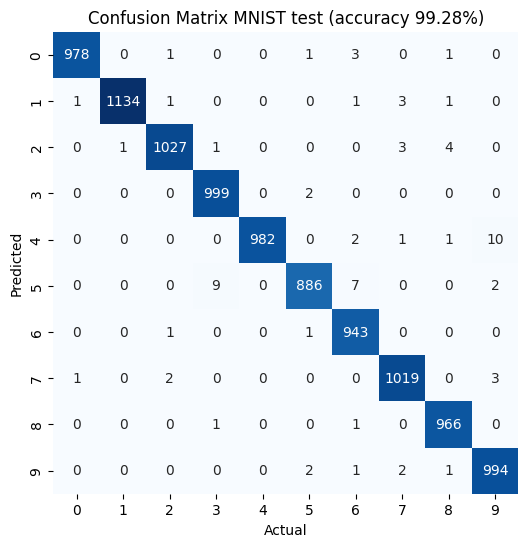

distribution:
 [1744 5099 4149 2882 2523 2384 1977 2019 1660 1595]
accuracy by class:
 [19. 86. 19. 13. 28. 25.  8. 38. 17.  8.]


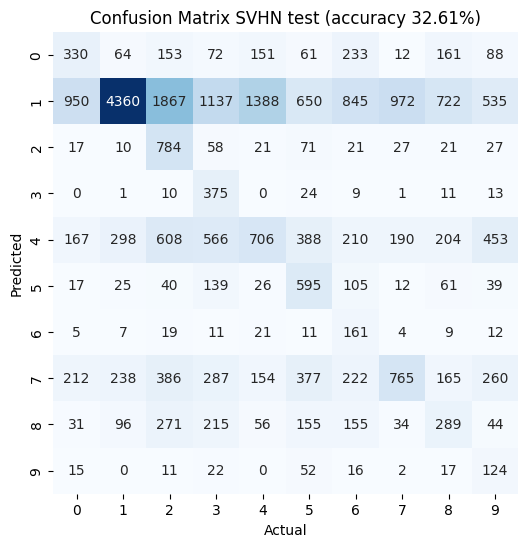

In [ ]:
# EVALUATE DANN

# MNIST_test
Ys_true_test, Ys_pred_test, Ys_proba_test = get_proba_pred_DANN(model, source_loader_test)
get_confusion_matrix(Ys_pred_test, Ys_true_test, title='MNIST test')

# SVHN_test
Yt_true_test, Yt_pred_test, Yt_proba_test = get_proba_pred_DANN(model, target_loader_test)
CFt_test_DANN = get_confusion_matrix(Yt_pred_test, Yt_true_test, title='SVHN test')


 # class 1 is being "over-predicted" by the model <br>=> downsize the number of pseudo labels for class 1 to balance data
 The model is predicting class 1 for a large majority of the images. We will downsize by 10 the number of pseudo labels for class 1 to balance data (which will improve overall accuracy on pseudo label, and learning capacities of model).

In [ ]:
# Evaluate the model
#---------------------
# Evaluate on training data
print('Evaluating on source training data')
evaluate(model, source_loader_train, source_loader_train, mode='Train')

# Evaluate on test data
print('Evaluating on source test data')
evaluate(model, source_loader_test, source_loader_test, mode='Test')

# Evaluate on target data
print('Evaluating on target data')
evaluate(model, target_loader_train, target_loader_train, mode='Train')

# Evaluate on test data
print('Evaluating on target test data')
evaluate(model, target_loader_test, target_loader_test, mode='Test')

# Save the model
#----------------
torch.save(model.state_dict(), 'dann_svhn.pth')



Evaluating on source training data


KeyboardInterrupt: 

**1ST PSEUDO LABELLING ITERATION**

In [ ]:
############################################################
# RETRAINING WITH SOURCE = MNIST + SVHN WITH PSEUDO LABELS
# 
############################################################

#----------------------------------------------------------
# 1/ Get pseudo labels for SVHN for confident data
#----------------------------------------------------------

# get predictions for SVHN_train
Yt_train, Yt_pred_train, Yt_proba_train = get_proba_pred_DANN(model, target_loader_train, target_loader_train)

# get pseudo-label indices
threshold=0.9999
pseudo_labels, confident_indices = generate_pseudo_labels(train_dataset_target.data, Yt_pred_train, Yt_proba_train, threshold=threshold)
print('Number of confident samples:', len(confident_indices))
print('distribution of pseudo labels:\n',np.round(np.bincount(pseudo_labels)/len(confident_indices)*100,2),'\n')

# get true labels for confident data
Y_confident = np.array(Yt_train)[confident_indices]

# show confusion matrix between pseudo labels and true labels
cf_pseudo = get_confusion_matrix(pseudo_labels, Y_confident, title='Pseudo labels')

Number of confident samples: 0
distribution of pseudo labels:
 [] 

distribution:
 []
accuracy by class:
 []


/tmp/ipykernel_63515/1782241449.py:120: RuntimeWarning: invalid value encountered in scalar divide
  accuracy = correct_count / np.sum(cf)


ValueError: zero-size array to reduction operation fmin which has no identity

<Figure size 600x600 with 0 Axes>

In [ ]:
# Calculate recall for "1" predictions (majority class)
#------------------------------------------------------

print(f'number of samples: {np.sum(cf_pseudo)}')
# Calculate precision and recall for "1" predictions
precision_1 = np.diag(cf_pseudo)[1] / np.sum(cf_pseudo[:,1])
recall_1 = np.diag(cf_pseudo)[1] / np.sum(cf_pseudo[1,:])
accuracy_1 = (np.diag(cf_pseudo)[1] + np.sum(np.delete(np.delete(cf_pseudo, 1, axis=0), 1, axis=1))) / np.sum(cf_pseudo)
print(f'for 1 labels:  recall:{recall_1}, precision:{precision_1},accuracy:{accuracy_1}')

# Calculate accuracy excluding "1" predictions (minority classses)
#-----------------------------------------------------------------
TP_other = np.sum(np.diag(cf_pseudo))-np.diag(cf_pseudo)[1]
precision_other = TP_other / (np.sum(cf_pseudo) - np.sum(cf_pseudo[:,1]))
recall_other = TP_other/ (np.sum(cf_pseudo)-np.sum(cf_pseudo[1,:]))
print(f'for other labels:  TP {TP_other}, recall:{recall_other}, precision:{precision_other}')


number of samples: 73172
for 1 labels:  recall:0.1894135182070531, precision:1.0,accuracy:0.18986770895971136
for other labels:  TP 34, recall:0.8292682926829268, precision:0.0005731625084288604


In [ ]:
#---------------------------------------------------------------
# 2/ CREATE NEW DATASET WITH CONFIDENT IMAGES & RETRAIN DANN MODEL
#---------------------------------------------------------------


from torch.utils.data import ConcatDataset, Subset

# Reduce the size of class 1 in the pseudo labels
#---------------------------------------------------
print(pseudo_labels[:5])
confident_indices_1 = confident_indices[pseudo_labels == 1]
confident_indices_not_1 = confident_indices[pseudo_labels != 1]
factor = 5
indices_1_to_keep = np.random.choice(confident_indices_1, int(len(confident_indices_1)/factor), replace=False)
new_confident_indices = np.concatenate([confident_indices_not_1, indices_1_to_keep])
new_pseudo_labels = pseudo_labels[indices_1_to_keep]
new_Y_confident = Y_confident[indices_1_to_keep]
print(f'New number of confident values (1s divided by factor {factor}): {len(new_confident_indices)} by class (0 to 9):\n{np.bincount(new_pseudo_labels)}')
get_confusion_matrix(new_pseudo_labels, new_Y_confident, title=f'- New pseudo labels (1s divided by factor 5)')
# Extract from the original dataset, the confident images and their pseudo labels
# Extract from the original dataset, the confident images and their pseudo labels
target_train_with_pseudolabels = SVHNWithPseudoLabels(train_dataset_target, new_confident_indices, new_pseudo_labels)

pseudo_loader = DataLoader(target_train_with_pseudolabels, batch_size=bs, shuffle=True, drop_last=True)

# Extract from the original dataset, the not-confident images and keep original labels
not_confident_indices = np.setdiff1d(np.arange(len(train_dataset_target)), confident_indices)
target_train_not_confident = Subset(train_dataset_target, not_confident_indices)
print(len(target_train_not_confident))
not_confident_loader = DataLoader(target_train_not_confident, batch_size=bs, shuffle=True, drop_last=True)

# Concatenante MNIST and pseudo datasets
new_training_dataset = ConcatDataset([train_dataset_source, target_train_with_pseudolabels])
new_training_loader = DataLoader(new_training_dataset, batch_size=bs, shuffle=True, drop_last=True)

# train DANN model on new_training_loader
#-----------------------------------------

model_pseudo = DANN_Srivastavas().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_pseudo.parameters(), lr=0.0001)  # !!! DO NOT CHANGE LEARNING RATE IF ADAM OPTIMISER USED !!!
n_epochs = 3

# Train the model (with new_training_loader)
history_pseudo = train_CNN(model_pseudo, new_training_loader, source_loader_test, epochs=n_epochs, lr=0.0001) #!!! KEEP LEARNING RATE = 0.0001 IF ADAM OPTIMISER USED !!!

# EVALUATE DANN

# MNIST_test
Ys_true_test, Ys_pred_test, Ys_proba_test = get_proba_pred_DANN(model, source_loader_test)
get_confusion_matrix(Ys_pred_test, Ys_true_test, title='MNIST test')

# SVHN_test
Yt_true_test, Yt_pred_test, Yt_proba_test = get_proba_pred_DANN(model, target_loader_test)
CFt_test_ANN = get_confusion_matrix(Yt_pred_test, Yt_true_test, title='SVHN test')

[]
New number of confident values (1s divided by factor 5): 0 by class (0 to 9):
[]
distribution:
 []
accuracy by class:
 []


/tmp/ipykernel_63515/1782241449.py:120: RuntimeWarning: invalid value encountered in scalar divide
  accuracy = correct_count / np.sum(cf)


ValueError: zero-size array to reduction operation fmin which has no identity

<Figure size 600x600 with 0 Axes>